In [2]:
import os
import glob
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Configuration
POSITIVE_DIR = "/content/DDS1/PP/IMAGE"
NEGATIVE_DIR = "/content/DDS1/NP/IMAGE"

# Global Params
IMG_WIDTH = 40
IMG_HEIGHT = 40
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

TEST_SPLIT_SIZE = 0.2
CNN_VALIDATION_SPLIT = 0.2
CNN_EPOCHS = 15
CNN_BATCH_SIZE = 32

In [4]:
def load_and_preprocess_images(positive_dir, negative_dir):
    images = []
    labels = []

    print(f"Loading images from: {positive_dir} (Label 1)")
    pos_files = glob.glob(os.path.join(positive_dir, "*.bmp"))
    print(f"Found {len(pos_files)} positive images.")

    for img_path in pos_files:
        try:
            img = cv2.imread(img_path)
            if img is None: continue
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            if len(img_resized.shape) == 2 or img_resized.shape[2] == 1:
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            images.append(img_resized)
            labels.append(1)
        except Exception as e: pass

    print(f"Loading images from: {negative_dir} (Label 0)")
    neg_files = glob.glob(os.path.join(negative_dir, "*.bmp"))
    print(f"Found {len(neg_files)} negative images.")

    for img_path in neg_files:
        try:
            img = cv2.imread(img_path)
            if img is None: continue
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            if len(img_resized.shape) == 2 or img_resized.shape[2] == 1:
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            images.append(img_resized)
            labels.append(0)
        except Exception as e: pass

    print("Converting to NumPy arrays and normalizing...")
    images_np = np.array(images, dtype="float32") / 255.0
    labels_np = np.array(labels, dtype="int32")
    return images_np, labels_np

In [5]:
# Original CNN Structure
def build_cnn_model(input_shape, dropout_rate=0.5):
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Feature Layer
    feature_output = layers.Dense(128, activation='relu', name='feature_layer')(x)

    # Classifier Head (Variable Dropout)
    x = layers.Dropout(dropout_rate)(feature_output)
    classifier_output = layers.Dense(1, activation='sigmoid', name='classifier_head')(x)

    model = keras.Model(inputs=inputs, outputs=classifier_output, name=f"CustomCNN_Drop{dropout_rate}")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ResNet block
def residual_block(x, filters, stride=1):
    shortcut = x
    # Main path
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut path
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet10_model(input_shape, dropout_rate=0.5):
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Initial Conv
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ResNet-10 = 4 blocks of 2 layers
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=2)  # Downsample 40 -> 20
    x = residual_block(x, 128, stride=2) # Downsample 20 -> 10
    x = residual_block(x, 256, stride=2) # Downsample 10 -> 5

    # Global Average Pooling replaces Flatten
    x = layers.GlobalAveragePooling2D()(x)

    # Feature Layer
    feature_output = layers.Dense(128, activation='relu', name='feature_layer')(x)

    # Classifier Head
    x = layers.Dropout(dropout_rate)(feature_output)
    classifier_output = layers.Dense(1, activation='sigmoid', name='classifier_head')(x)

    model = keras.Model(inputs=inputs, outputs=classifier_output, name=f"ResNet10_Drop{dropout_rate}")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def run_experiments():
    print("--- Starting Comparative Study ---")

    # Load Data ONCE
    try:
        all_images, all_labels = load_and_preprocess_images(POSITIVE_DIR, NEGATIVE_DIR)
    except Exception as e:
        print(f"Error loading images: {e}")
        return

    if len(all_images) == 0:
        print("No images found. Check paths.")
        return

    X_train, X_test, y_train, y_test = train_test_split(
        all_images, all_labels, test_size=TEST_SPLIT_SIZE, stratify=all_labels, random_state=42
    )

    # Class weights
    class_weights_dict = {0: 1.0, 1: 4.0}

    # Define Experiments
    dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
    results = []

    print(f"\nRunning experiments on {len(dropout_rates)} dropout rates for both models...")

    # EXPERIMENT LOOP
    for rate in dropout_rates:
        # Test Original CNN
        print(f"\n[Experiment] Training Custom CNN with Dropout={rate}")
        model_cnn = build_cnn_model(IMG_SHAPE, dropout_rate=rate)

        # Early stopping to save time if it stops improving
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model_cnn.fit(
            X_train, y_train,
            epochs=CNN_EPOCHS,
            batch_size=CNN_BATCH_SIZE,
            validation_split=CNN_VALIDATION_SPLIT,
            class_weight=class_weights_dict,
            callbacks=[early_stop],
            verbose=0 # Silent training
        )

        # Evaluate
        preds_cnn = model_cnn.predict(X_test).ravel()
        preds_class_cnn = (preds_cnn > 0.5).astype(int)
        auc_cnn = roc_auc_score(y_test, preds_cnn)
        acc_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)[1]
        f1_cnn = f1_score(y_test, preds_class_cnn)

        results.append({
            "Model": "Custom CNN",
            "Dropout": rate,
            "AUC": auc_cnn,
            "F1_Score": f1_cnn,
            "Accuracy": acc_cnn
        })
        print(f"   -> Result: AUC={auc_cnn:.4f}, Acc={acc_cnn:.4f}")

        # Test ResNet-10
        print(f"[Experiment] Training ResNet-10 with Dropout={rate}")
        model_res = build_resnet10_model(IMG_SHAPE, dropout_rate=rate)

        model_res.fit(
            X_train, y_train,
            epochs=CNN_EPOCHS,
            batch_size=CNN_BATCH_SIZE,
            validation_split=CNN_VALIDATION_SPLIT,
            class_weight=class_weights_dict,
            callbacks=[early_stop],
            verbose=0
        )

        preds_res = model_res.predict(X_test).ravel()
        preds_class_res = (preds_res > 0.5).astype(int)
        auc_res = roc_auc_score(y_test, preds_res)
        acc_res = model_res.evaluate(X_test, y_test, verbose=0)[1]
        f1_res = f1_score(y_test, preds_class_res)

        results.append({
            "Model": "ResNet-10",
            "Dropout": rate,
            "AUC": auc_res,
            "F1_Score": f1_res,
            "Accuracy": acc_res
        })
        print(f"   -> Result: AUC={auc_res:.4f}, Acc={acc_res:.4f}")

    # FINAL REPORT
    print("\n\n=== FINAL EXPERIMENT RESULTS ===")
    df_results = pd.DataFrame(results)
    print(df_results)

    df_results.to_csv("model_comparison_results.csv", index=False)

    # Plot AUC
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_results, x='Dropout', y='AUC', hue='Model', marker='o')
    plt.title("Model Comparison: AUC vs Dropout Rate")
    plt.grid(True)
    plt.show()

    # Plot F1
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_results, x='Dropout', y='F1_Score', hue='Model', marker='o')
    plt.title("Model Comparison: F1 Score vs Dropout Rate")
    plt.grid(True)
    plt.show()

--- Starting Comparative Study ---
Loading images from: /content/DDS1/PP/IMAGE (Label 1)
Found 2636 positive images.
Loading images from: /content/DDS1/NP/IMAGE (Label 0)
Found 28848 negative images.
Converting to NumPy arrays and normalizing...

Running experiments on 5 dropout rates for both models...

[Experiment] Training Custom CNN with Dropout=0.1
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
   -> Result: AUC=0.9968, Acc=0.9914
[Experiment] Training ResNet-10 with Dropout=0.1
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
   -> Result: AUC=0.9969, Acc=0.9868

[Experiment] Training Custom CNN with Dropout=0.2
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   -> Result: AUC=0.9969, Acc=0.9911
[Experiment] Training ResNet-10 with Dropout=0.2
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
   -> Result: AUC=0.9994, Acc=0.9956

[Experiment] Training Custom CNN with Dropout=0.3
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   -> Result: AUC=0.9978, Acc=0.9921
[Experiment] Training ResNet-10 with Dropout=0.3
197

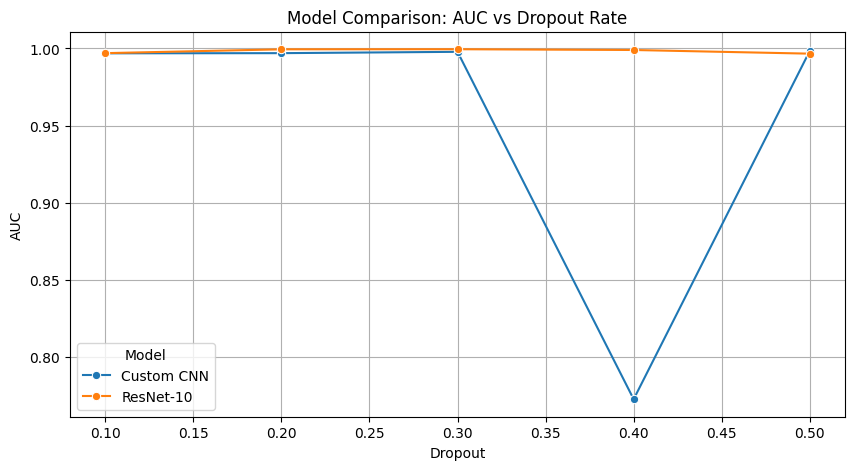

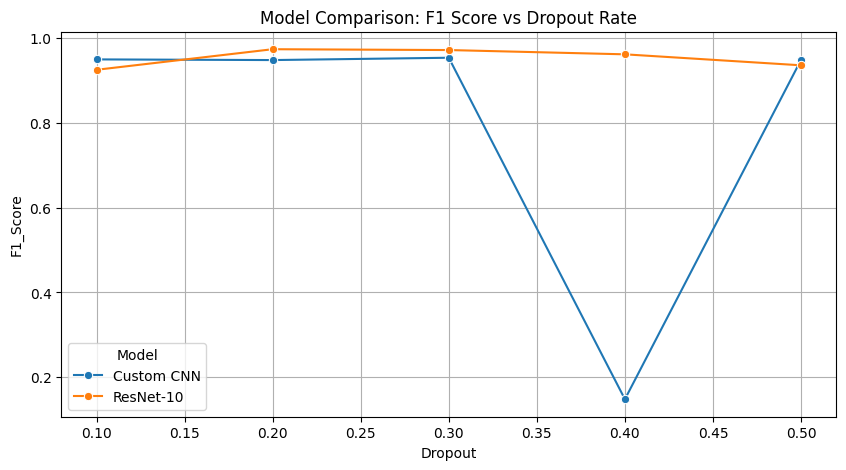

In [7]:
if __name__ == "__main__":
    run_experiments()

In [11]:
from IPython.display import display

data = {
    'Model': [
        'Custom CNN', 'ResNet-10',
        'Custom CNN', 'ResNet-10',
        'Custom CNN', 'ResNet-10',
        'Custom CNN', 'ResNet-10',
        'Custom CNN', 'ResNet-10'
    ],
    'Dropout': [
        0.1, 0.1,
        0.2, 0.2,
        0.3, 0.3,
        0.4, 0.4,
        0.5, 0.5
    ],
    'AUC': [
        0.996825, 0.996935,
        0.996928, 0.999411,
        0.997790, 0.999474,
        0.772777, 0.998974,
        0.998420, 0.996601
    ],
    'F1_Score': [
        0.949533, 0.925023,
        0.947955, 0.973535,
        0.953445, 0.971591,
        0.148148, 0.961502,
        0.948435, 0.935606
    ],
    'Accuracy': [
        0.991425, 0.986819,
        0.991107, 0.995553,
        0.992060, 0.995236,
        0.901382, 0.993489,
        0.991107, 0.989201
    ]
}

# Create DataFrame
df_results = pd.DataFrame(data)

# Sort by F1 Score (Descending) and take top 5
top_5_models = df_results.sort_values(by="F1_Score", ascending=False).head(5)

# Reset the index so it counts 1, 2, 3, 4, 5
top_5_models = top_5_models.reset_index(drop=True)
top_5_models.index += 1

# Rename columns
top_5_models = top_5_models.rename(columns={
    "F1_Score": "F1-Score",
    "Accuracy": "Accuracy",
    "AUC": "AUC Score"
})

# Display table
print("--- Table I: Top 5 Performing Models ---")
display(top_5_models.style.background_gradient(cmap='Blues', subset=['F1-Score', 'AUC Score'])
        .format("{:.4f}", subset=['AUC Score', 'F1-Score', 'Accuracy'])
        .format("{:.1f}", subset=['Dropout']))

--- Table I: Top 5 Performing Models ---


,Model,Dropout,AUC Score,F1-Score,Accuracy
1,ResNet-10,0.2,0.9994,0.9735,0.9956
2,ResNet-10,0.3,0.9995,0.9716,0.9952
3,ResNet-10,0.4,0.9990,0.9615,0.9935
4,Custom CNN,0.3,0.9978,0.9534,0.9921
5,Custom CNN,0.1,0.9968,0.9495,0.9914
